In [4]:
import pandas as pd
import numpy as np
import sklearn
from scipy.stats import skew, kurtosis
from scipy.stats import describe
from scipy.stats.mstats import gmean
import matplotlib.pyplot as plt
import scipy.linalg
import pprint as pprint
import time as time
from sklearn.decomposition import PCA

In [ ]:
# Problem 1

#if x and y is normal, can just use multivariate normal, y = f(X, epsilon)


#matrix of [X E] ~ N(u,E)
#X ~ N(u, E)
#E ~ N(0, I)
#y = f(X, epsilon)
#epsilon ~ N(0, I)

#matrix = Sigma

#[x epsilon] ~ (u,sigma)   where u = [x1 zero]

#y = f(x, epsilon)   observed x and epsilon which is error term to get y  There is a beta value there usually

,x
0,-0.002665
1,-0.045128
2,0.053635
3,0.010450
4,-0.016284


VaR: 8.1255
ES: 11.1715


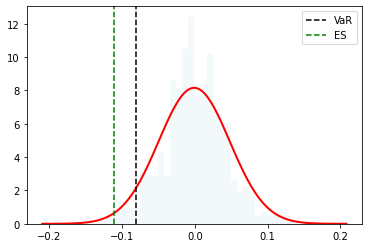

In [40]:

from scipy.stats import norm
from scipy.stats import rv_continuous
from scipy.integrate import quad
from scipy.optimize import curve_fit
import matplotlib.pyplot as plt

# Read in the CSV file with pandas
data = pd.read_csv('problem1.csv')

#convert to numpy array
# data = data.to_numpy()

def fit_normal(x):
    x = x.to_numpy()
    # Mean and Std values
    m = np.mean(x)
    s = np.std(x)
    
    # Create the error model
    error_model = norm(m, s)
    
    # Calculate the errors and U
    errors = x - m
    u = error_model.cdf(x)
    
    # Define the evaluation function
    def eval_func(u):
        return error_model.ppf(u)
    
    # Return the fitted model
    return {"errors": errors, "u": u, "eval": eval_func, "model": error_model}


NormDistFitted = fit_normal(data)

num_simulations = 1000
simulated_value = NormDistFitted['model'].rvs(num_simulations)



def VaRFittedNormal(data, alpha = .05):
    NormDistFitted = fit_normal(data)
    var = -NormDistFitted['model'].ppf(alpha)
    pdf = NormDistFitted['model'].pdf
    def ES_func_norm(x):
        return x * pdf(x)
    ES, _ = quad(ES_func_norm, -np.inf, var)
    ES = -ES / alpha
    return {"VaR": var, "ES": ES}

# Calculate VaR
alpha = 0.05 
var = -NormDistFitted['model'].ppf(alpha)
pdf = NormDistFitted['model'].pdf


# Calculate Expected Shortfall

def ES_func_norm(x):
    return x * pdf(x)

ES, _ = quad(ES_func_norm, -np.inf, var)
ES = -ES / alpha

# Print the results
print('VaR: {:.4f}'.format(var*100))
print('ES: {:.4f}'.format(ES*100))

# Plot the histogram of the data
plt.hist(data, bins=50, density=True, alpha=0.05)

# Plot the fitted PDF
x = np.linspace(np.min(data), np.max(data), 100)
y = NormDistFitted['model'].pdf(x)
plt.plot(x, y, 'r-', lw=2)

# Plot VaR and Expected Shortfall lines
plt.axvline(-var, color='black', linestyle='--', label='VaR')
plt.axvline(-ES, color='green', linestyle='--', label='ES')

plt.legend()
plt.show()



In [11]:
def VaRFittedNormal(data, alpha = .05):
    NormDistFitted = fit_normal(data)
    var = -NormDistFitted['model'].ppf(alpha)
    pdf = NormDistFitted['model'].pdf
    def ES_func_norm(x):
        return x * pdf(x)
    ES, _ = quad(ES_func_norm, -np.inf, var)
    ES = -ES / alpha
    return {"VaR": var, "ES": ES}

results = VaRFittedNormal(data, alpha = .05)
print(results)

{'VaR': 0.08125483171032236, 'ES': 0.11171522323912937}


In [37]:
def VaRFittedNormalSimulated(data, alpha=0.05, num_simulations=1000):
    NormDistFitted = fit_normal(data)
    simulated_value = NormDistFitted['model'].rvs(num_simulations)
    var = -np.quantile(simulated_value, alpha)
    pdf = NormDistFitted['model'].pdf
    def ES_func_norm(x):
        return x * pdf(x)
    ES, _ = quad(ES_func_norm, -np.inf, var)
    ES = -ES / alpha
    return {"VaR": var, "ES": ES}

stuff = VaRFittedNormal(data, alpha = .05, num_simulations= 1000)
print(stuff)

{'VaR': 0.07806454132319025, 'ES': 0.12238321720750951}


In [9]:
from scipy.stats import norm
from scipy.integrate import quad
import numpy as np

def fit_normal(x):
    # Mean and Std values
    m = np.mean(x)
    s = np.std(x)
    
    # Create the error model
    error_model = norm(m, s)
    
    # Calculate the errors and U
    errors = x - m
    u = error_model.cdf(x)
    
    # Define the evaluation function
    def eval_func(u):
        return error_model.ppf(u)
    
    # Return the fitted model
    return {"errors": errors, "u": u, "eval": eval_func, "model": error_model}

def calc_VaR_from_Fitted(fitted_data):
    NormDistFitted = fit_normal(data)
    
    # Calculate the var value
    var = -NormDistFitted['model'].ppf(alpha)

def calc_ES(data, alpha):
    # Fit the normal distribution to the data
    NormDistFitted = fit_normal(data)
    
    # Calculate the var value
    var = -NormDistFitted['model'].ppf(alpha)
    
    # Define the ES function
    def ES_func_norm(x):
        return x * NormDistFitted['model'].pdf(x) / alpha if x <= var else NormDistFitted['eval'](x) - var
    
    # Calculate the ES using quadrature integration
    ES, _ = quad(ES_func_norm, -np.inf, np.inf)
    ES = -ES
    
    return ES

data = pd.read_csv('problem1.csv')

data = data.to_numpy()
ExpShortfall = calc_ES(data, alpha = .05)

C:\Users\Moneybag Mike\AppData\Roaming\Python\Python37\site-packages\ipykernel_launcher.py:36: IntegrationWarning: The occurrence of roundoff error is detected, which prevents 
  the requested tolerance from being achieved.  The error may be 
  underestimated.


VaR: 7.6476
ES: 11.4446


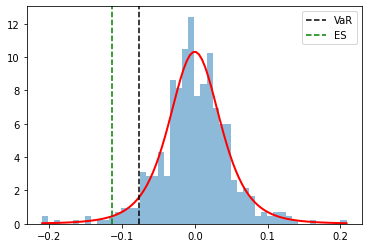

In [53]:
from scipy.stats import t
import numpy as np
import scipy.stats as stats
from scipy.optimize import minimize

import numpy as np

from scipy.optimize import minimize

data = pd.read_csv('problem1.csv')

#convert to numpy array
# data = data.to_numpy()


def general_t_ll(mu, s, nu, x):
    td = t(nu)
    log_pdf = td.logpdf((x - mu) / s) - np.log(s)
    return -np.sum(log_pdf)

def fit_general_t(x):
    x = x.to_numpy()
    # Approximate values based on moments
    start_m = np.mean(x)
    start_nu = 6.0 / stats.kurtosis(x) + 4
    start_s = np.sqrt(np.var(x) * (start_nu - 2) / start_nu)

    def _gtl(theta):
        return general_t_ll(*theta, x)

    bounds = ((None, None), (1e-6, None), (2.0001, None))
    result = minimize(_gtl, (start_m, start_s, start_nu), bounds=bounds)

    m, s, nu = result.x
    t_dist_fitted = t(nu, loc=m, scale=s)
    return {'m': m, 's': s, 'nu': nu, 'model': t_dist_fitted}


TDistFitted = fit_general_t(data)

num_simulations = 1000
simulated_value = TDistFitted['model'].rvs(num_simulations)

# # Calculate VaR
# alpha = 0.05 
# var = -TDistFitted['model'].ppf(alpha)
# pdf = TDistFitted['model'].pdf

# # Calculate Expected Shortfall
# def ES_func(x):
#     return x * pdf(x)

# ES, _ = quad(ES_func, -np.inf, var)
# ES = -ES / alpha

# Calculate VaR t dist
alpha = 0.05 
var = -TDistFitted['model'].ppf(alpha)

# Calculate Expected Shortfall
def ES_func_t(x):
    return x * TDistFitted['model'].pdf(x) / alpha

ES, _ = quad(ES_func_t, -np.inf, var)


# def calcVaRFittedT(data , alpha = .05):
#     TDistFitted = fit_general_t(data)
#     var = -TDistFitted['model'].ppf(alpha)
#     pdf = TDistFitted['model'].pdf
#     def ES_func_t(x):
#         return x * pdf(x) / alpha
#     ES, _ = quad(ES_func_t, -np.inf, var)
#     ES = -ES / alpha
#     return {"VaR": var, "ES": ES}

# Print the results
print('VaR: {:.4f}'.format(var*100))
print('ES: {:.4f}'.format(-ES*100))

# Plot the histogram of the data
plt.hist(data, bins=50, density=True, alpha=0.5)

# Plot the fitted PDF
x = np.linspace(np.min(data), np.max(data), 100)
y = TDistFitted['model'].pdf(x)
plt.plot(x, y, 'r-', lw=2)

# Plot VaR and Expected Shortfall lines
plt.axvline(-var, color='black', linestyle='--', label='VaR')
plt.axvline(ES, color='green', linestyle='--', label='ES')

plt.legend()
plt.show()


In [51]:
def calcVaRFittedT(data, alpha = .05):
    TDistFitted = fit_general_t(data)
    var = -TDistFitted['model'].ppf(alpha)
    pdf = TDistFitted['model'].pdf
    def ES_func_t(x):
        return x * pdf(x) / alpha
    ES, _ = quad(ES_func_t, -np.inf, var)
    ES = -ES / alpha
    return {"VaR": var, "ES": ES}




Tresult = calcVaRFittedT(data, alpha = .05)
print(Tresult)

c:\Users\Moneybag Mike\AppData\Local\Programs\Python\Python37\lib\site-packages\scipy\optimize\_minimize.py:491: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  x0 = np.asarray(x0)


TypeError: _parse_args() missing 1 required positional argument: 'df'

In [20]:
from QuantRiskTools import PortAnalytics



